###### Feature Information

PassengerID: Unique ID number

Survived: 0 = No, 1 = Yes

Pclass: Ticket class (1, 2, or 3)

Name: Passenger name

Sex: Male or Female

Age: Age in years

SibSp: # of siblings/spouses aboard the Titanic

Parch: # of parents/children aboard the Titanic

Ticket: Ticket #

Fare: Passenger fare

Cabin: Cabin number

Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

# Imports

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Obtain

Load train & test data as dataframes from csv files

In [2]:
# Import training/testing data using pandas

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_index = test.PassengerId

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Scrub

Check training data features for any null values or non-numeric data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


###### There are several immediate issues with the data:

1) Missing (null) values in the 'Age', 'Cabin', and 'Embarked' features

2) Non-numeric data is present in the 'Name', 'Sex', 'Ticket', 'Cabin', and 'Embarked' features.

The points should be addressed before further meaningful data analysis is performed.

###### 1) Handing 'Age' missing values

In [6]:
# Check value counts of age

train.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027168963048>]],
      dtype=object)

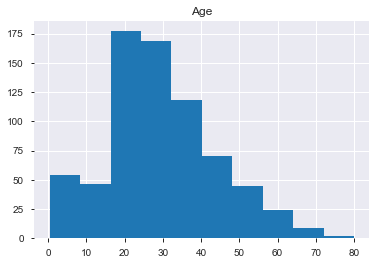

In [7]:
train.hist('Age')

In [8]:
# How many ages are missing?

train.Age.isna().sum()

177

In [9]:
# Replace nulls with median value for age

train.Age.fillna(train.Age.median(), inplace=True)

In [10]:
# Separate age data into bins for youths, adults, seniors to smooth the effect of
# filling null ages with median age

train['age_bins'] = pd.cut(x=train['Age'], 
                           bins=[0, 12, 19, 60, 80],
                          labels=['child', 'teen', 'adult', 'senior'])

In [11]:
# Check updated value counts for age (25 = 20-30 yr bin)

train['age_bins'].value_counts()

adult     705
teen       95
child      69
senior     22
Name: age_bins, dtype: int64

Since age_bins is stored categorically, will convert to dummy variables

In [12]:
dummies = pd.get_dummies(train['age_bins'])
train = pd.concat([train, dummies], axis=1)

In [13]:
train.drop(['age_bins', 'Age'], axis=1, inplace=True)

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child,teen,adult,senior
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C85,C,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,C123,S,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,NaN,S,0,0,1,0


###### 2) Handle 'Cabin' missing values

Since most of the data is missing, it is best to drop this feature entirely

In [15]:
# Drop cabin feature

train.drop('Cabin', axis=1, inplace=True)

In [16]:
# Check to make sure 'Cabin' removed

train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Embarked,child,teen,adult,senior
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,S,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,C,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,S,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,S,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,S,0,0,1,0


###### 3) Handle 'Embarked' missing values

In [17]:
# Let's see the distribution of values for 'Embarked'

train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
# Since most people embarked at 'S', we will fill the two null values with 'S'

train.Embarked.fillna('S', inplace=True)

train.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [19]:
dummies = pd.get_dummies(train.Embarked, prefix='Emb')

In [20]:
train = pd.concat([train, dummies], axis=1)

In [21]:
train.drop('Embarked', axis=1, inplace=True)

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,child,teen,adult,senior,Emb_C,Emb_Q,Emb_S
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,0,0,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,0,0,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,0,0,1,0,0,0,1


###### 4) Handling 'Sex' dtype

Since 'Embarked' is stored categorically, want to convert this to dummy variables

In [23]:
s_dummies = pd.get_dummies(train.Sex, prefix='sex')
train = pd.concat([train, s_dummies], axis=1)
train.drop('Sex', axis=1, inplace=True)

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Fare,child,teen,adult,senior,Emb_C,Emb_Q,Emb_S,sex_female,sex_male
0,1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,0,0,1,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,0,0,1,0,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,0,0,1,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,53.1000,0,0,1,0,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",0,0,373450,8.0500,0,0,1,0,0,0,1,0,1


###### 5) Handling 'Name' and 'Ticket' features

Since I don't see any real way to extract meaningful information from these, I will drop these from my training data.

In [25]:
train.drop(['Name', 'Ticket'], axis=1, inplace=True)

In [26]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,child,teen,adult,senior,Emb_C,Emb_Q,Emb_S,sex_female,sex_male
0,1,0,3,1,0,7.2500,0,0,1,0,0,0,1,0,1
1,2,1,1,1,0,71.2833,0,0,1,0,1,0,0,1,0
2,3,1,3,0,0,7.9250,0,0,1,0,0,0,1,1,0
3,4,1,1,1,0,53.1000,0,0,1,0,0,0,1,1,0
4,5,0,3,0,0,8.0500,0,0,1,0,0,0,1,0,1


###### Final check of first pass at scrubbing

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
child          891 non-null uint8
teen           891 non-null uint8
adult          891 non-null uint8
senior         891 non-null uint8
Emb_C          891 non-null uint8
Emb_Q          891 non-null uint8
Emb_S          891 non-null uint8
sex_female     891 non-null uint8
sex_male       891 non-null uint8
dtypes: float64(1), int64(5), uint8(9)
memory usage: 49.7 KB


# Explore

Taking another look at each variable, so see if anything needs bo be adjusted before beginning modeling.

In [28]:
# Run pandas profiling report on our scrubbed training dataset

pp.ProfileReport(train)

I am now going to drop the 'Age' and 'PassengerId' features. 'Age' is highly correlated to 'age_bins' and will therefore be redundant, an 'PassengerId' isn't going to provide any useful information.

In [29]:
train.drop(['PassengerId'], axis=1, inplace=True)

In [30]:
train.head()

,Survived,Pclass,SibSp,Parch,Fare,child,teen,adult,senior,Emb_C,Emb_Q,Emb_S,sex_female,sex_male
0,0,3,1,0,7.2500,0,0,1,0,0,0,1,0,1
1,1,1,1,0,71.2833,0,0,1,0,1,0,0,1,0
2,1,3,0,0,7.9250,0,0,1,0,0,0,1,1,0
3,1,1,1,0,53.1000,0,0,1,0,0,0,1,1,0
4,0,3,0,0,8.0500,0,0,1,0,0,0,1,0,1


In [31]:
pp.ProfileReport(train)

## Feature Engineering

I want to see if being alone or with family has any real impact on predicting whether someone survived. I will create a new column called 'Alone', which will be dependent on whether the passenger had any non-zero result in the 'SibSp' or the 'Parch' categories. I will then keep the 'Alone' column in place of 'SibSp' and 'Parch' for simplicity.

In [32]:
train['Alone'] = np.where((train['SibSp'] + train['Parch']) == 0, 1, 0)
train.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [33]:
train.head()

,Survived,Pclass,Fare,child,teen,adult,senior,Emb_C,Emb_Q,Emb_S,sex_female,sex_male,Alone
0,0,3,7.2500,0,0,1,0,0,0,1,0,1,0
1,1,1,71.2833,0,0,1,0,1,0,0,1,0,0
2,1,3,7.9250,0,0,1,0,0,0,1,1,0,1
3,1,1,53.1000,0,0,1,0,0,0,1,1,0,0
4,0,3,8.0500,0,0,1,0,0,0,1,0,1,1


# Model

First, let's assign our features and target to X and y

In [34]:
X = train.drop('Survived', axis=1)
y = train.Survived

Next, let's define a function to perform KFold cross validation for any classifier we want to use, and returns the accuracy score for each split as well as the mean cross validation accuracy.

In [35]:
def cross_val_acc(X, y, classifier, n_splits, random_state=None):
    
    from sklearn.model_selection import KFold
    from sklearn.metrics import accuracy_score
    
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    
    scores = []
    for train_index, test_index in cv.split(X):
        classifier.fit(X.iloc[train_index], y.iloc[train_index])
        y_pred = classifier.predict(X.iloc[test_index])
        y_true = y.iloc[test_index]
        scores.append(accuracy_score(y_true, y_pred))

    print(f"Accuracy Scores: {scores}")
    print(f"Mean Cross Val. Acc.: {round(np.mean(scores), 2)}")

## Zero Rule (ZeroR) Classifier

This is a great baseline classifier for a binary classification problem like this. The ZeroR classifier simply predicts the majority class in your dataset (i.e., mode).

In [36]:
zero_r_clf = round(len(train.loc[train.Survived == 0]) / len(train), 2)

In [37]:
print(f"ZeroR (Baseline) Classifier Accuracy is: {zero_r_clf}")

ZeroR (Baseline) Classifier Accuracy is: 0.62


So, the baseline ZeroR classifier (which only predicts the majority class) will be right about 62% of the time (i.e., if we predict that everyone died, we will be 62% accurate). This is a good starting point for more sophisticated classifiers.

## Gender Classifier

In [38]:
gender_clf = []
for i in train.sex_male:
    if i == 1:
        gender_clf.append(0)
    else:
        gender_clf.append(1)
        
gender_clf_score = round(accuracy_score(y, gender_clf), 2)

In [39]:
print(f"Gender Classifier Accuracy is: {gender_clf_score}")

Gender Classifier Accuracy is: 0.79


By simply predicting that all males die, we achieve 79 % accuracy on the training set.

## Random Forest Classifier

In [40]:
# Instantiate a random forest classifier

rf_clf = RandomForestClassifier(random_state=1)

In [41]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, rf_clf, n_splits=5, random_state=1)

Accuracy Scores: [0.7653631284916201, 0.7808988764044944, 0.8314606741573034, 0.848314606741573, 0.848314606741573]
Mean Cross Val. Acc.: 0.81


## Random Forest with GridSearchCV

In [42]:
# Perform grid search with GridSearchCV to try to find optimal parameters

rf = RandomForestClassifier(random_state=1)

grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10],
       'min_samples_leaf': [1, 5], 'max_features': ['auto', 0.5]}

rf = GridSearchCV(rf, grid, scoring='accuracy')
rf.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=1,
                                

In [43]:
# View best parameters found in grid search

best_rf_params = rf.best_params_

best_rf_params

{'max_depth': None,
 'max_features': 0.5,
 'min_samples_leaf': 5,
 'n_estimators': 50}

Checking best Random Forest params with a manual cross validation

In [47]:
# Instantiate an xg boost classifier with tuned params

rf = RandomForestClassifier(**best_rf_params)

In [48]:
# Perform 5-fold cross validation to get accuracy

cross_val_acc(X, y, rf, n_splits=5, random_state=1)

Accuracy Scores: [0.7821229050279329, 0.7865168539325843, 0.8089887640449438, 0.8426966292134831, 0.848314606741573]
Mean Cross Val. Acc.: 0.81


Checking best Random Forest params with a simple train-test split

In [49]:
# perform train-test split on data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [50]:
# Check shapes of resulting variables

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((668, 12), (223, 12), (668,), (223,))

In [51]:
# Fit tuned xg boost classifier on training data

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
# Predict values

y_pred = rf.predict(X_test)

In [53]:
accuracy_score(y_test, y_pred)

0.7982062780269058

Let's see how the best Random Forest classifier performs on 100 iterations of a random train-test split.

In [54]:
acc_scores = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                       random_state=i)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc_scores.append(accuracy_score(y_test, y_pred))
    
print(np.mean(acc_scores))

0.8216143497757846


So, over 100 random train-test splits of the data, XGBoost still gets about 84% accuracy - nearly all splits are between ~ 79 and 89 % accuracy.

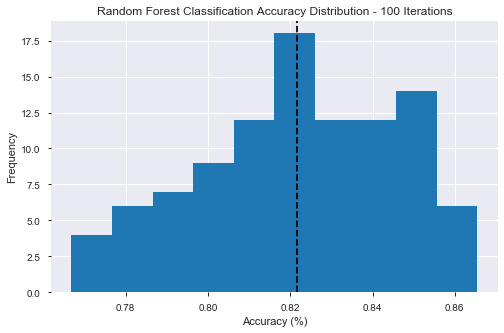

In [55]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(acc_scores)
ax.axvline(x=np.mean(acc_scores), color='black', linestyle='--')
ax.set_xlabel('Accuracy (%)')
ax.set_ylabel('Frequency')
ax.set_title('Random Forest Classification Accuracy Distribution - 100 Iterations');

## Make predictions on unlabeled data

First, I need to clean up the test dataset by doing the same transformations that were applied to the test set. Let's define a quick dataframe cleaner function to do this.

In [56]:
def clean_df(df):
    
    # Replace nulls with median value for age
    df.Age.fillna(df.Age.median(), inplace=True)
    
    # Separate age data into bins for every 10 years, to smooth the effect of
    # filling null ages with median age
    df['age_bins'] = pd.cut(x=df['Age'], 
                           bins=[0, 12, 19, 60, 80],
                          labels=['child', 'teen', 'adult', 'senior'])
    
    dummies = pd.get_dummies(df['age_bins'])
    df = pd.concat([df, dummies], axis=1)
    df.drop(['age_bins', 'Age'], axis=1, inplace=True)
    
    # Drop cabin feature
    df.drop('Cabin', axis=1, inplace=True)
    
    # Since most people embarked at 'S', we will fill  null values with 'S'
    df.Embarked.fillna('S', inplace=True)
    dummies = pd.get_dummies(df.Embarked, prefix='Emb')
    df = pd.concat([df, dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
    
    # Handling sex category
    s_dummies = pd.get_dummies(df.Sex, prefix='sex')
    df = pd.concat([df, s_dummies], axis=1)
    df.drop('Sex', axis=1, inplace=True)
    
    # Drop name and ticket features
    df.drop(['Name', 'Ticket'], axis=1, inplace=True)
    
    # Drop age and passengerid
    df.drop(['PassengerId'], axis=1, inplace=True)
    
    # Feature Engineering 'Alone'
    df['Alone'] = np.where((df['SibSp'] + df['Parch']) == 0, 1, 0)
    df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    
    return df

In [57]:
test = clean_df(test)

Below I check the pandas profiling report to see if there are any issues

In [59]:
pp.ProfileReport(test)

It looks like there is one null value in the 'Fare' category. Likely was intended to be a zero(?)

In [60]:
test.Fare.fillna(0, inplace=True)

In [61]:
test.Fare.isna().sum()

0

Now I can use the test dataset to predict on the unlabeled data.

In [62]:
final_clf = RandomForestClassifier(**best_rf_params)
final_clf.fit(X, y)
final_preds = final_clf.predict(test)

In [63]:
submission = pd.DataFrame([])

In [64]:
submission['PassengerId'] = test_index
submission['Survived'] = final_preds

In [65]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [66]:
submission.to_csv('submission_3.csv')